# Ada Final Project - EDA

In [4]:
# Python Standard Libraries
import re
import csv
import bz2
import json
import string

# Install using conda
# conda install matplotlib pandas ipywidgets beautifulsoup4 nltk
import nltk
#import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

from nltk.sentiment import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup


# Not available through Conda
#!pip  install syllables transformers

import syllables

# BERT related modules
from transformers import BertTokenizer, BertModel


%matplotlib inline

nltk.download([
     "names",
     "stopwords",
     "averaged_perceptron_tagger",
     "vader_lexicon",
     "punkt",
 ]);

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
[nltk_data] Downloading package names to /Users/daynex/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daynex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/daynex/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/daynex/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/daynex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
PATH_TO_FILE = 'data/hillary-and-trump-quotes-2016.json.bz2'

CEFR_HTML_IN = "data/cefr_data.html"
CEFR_CSV_OUT = "data/cefr_data.csv"

CHUNK_SIZE = 100_000

RANDOM_SAMPLE_SIZE = 1_000

SEED = 92813

## 1. Load Data

### Initial Data Extraction

For reference we include the code we executed on Google Colab to extract all quotes by **Hillary Clinton** and **Donald Trump** during the **year 2016** from the Quotebank dataset. This was a one time operation, which is why we did it outside of this notebook. All other algorithms we apply to the data will be/have been possibly iterated on for improvement, which is where the notebook format comes in handy.

```python
PATH_TO_FILE = '/content/drive/MyDrive/Quotebank/quotes-2016.json.bz2'
PATH_TO_OUT = '/content/drive/MyDrive/hillary-and-trump-quotes-2016.json.bz2'

SPEAKER_NAMES = ['Hillary Clinton', 'Donald Trump']

hits = 0

with bz2.open(PATH_TO_FILE, 'rb') as s_file:
    with bz2.open(PATH_TO_OUT, 'wb') as d_file:

        for instance in s_file:

            instance = json.loads(instance)
            speaker = instance['speaker']

            if any(map(speaker.__contains__, desired_speakers)):

                d_file.write((json.dumps(instance)+'\n').encode('utf-8'))

                hits += 1


print(f"Hits: {hits}")
```

In [6]:
df_1 = pd.read_json(PATH_TO_FILE, lines=True, compression='bz2') #chunksize=CHUNK_SIZE)

## 2. Enhance Data

In [7]:
df_2 = df_1

df_2['proba'] = df_2['probas'].apply(lambda probas : float(probas[0][1]))

df_2.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,proba
0,2016-07-11-000226,[ I ] mmigration has been and continues to be ...,Hillary Clinton,[Q6294],2016-07-11 17:26:06,1,"[[Hillary Clinton, 0.9025], [None, 0.0975]]",[http://www.breitbart.com/tech/2016/07/11/hill...,E,0.9025
1,2016-07-28-001820,a little bit personally.,Donald Trump,"[Q22686, Q27947481]",2016-07-28 10:26:34,2,"[[Donald Trump, 0.7921], [None, 0.1568], [Bria...",[http://lcsun-news.com/story/news/politics/onp...,E,0.7921
2,2016-08-27-001626,A vote for Clinton is a vote for open borders.,Donald Trump,"[Q22686, Q27947481]",2016-08-27 23:31:11,1,"[[Donald Trump, 0.8488], [None, 0.1176], [Hill...",[http://whotv.com/2016/08/27/trump-takes-stage...,E,0.8488
3,2016-05-24-003322,"Additionally, all sorts of `horrors' had been ...",Donald Trump,"[Q22686, Q27947481]",2016-05-24 08:59:38,1,"[[Donald Trump, 0.6887], [None, 0.2613], [Matt...",[http://nmpolitics.net/index/2016/05/do-the-up...,E,0.6887
4,2016-08-20-002872,AMERICA is once again at a moment of reckoning...,Hillary Clinton,[Q6294],2016-08-20 06:02:42,1,"[[Hillary Clinton, 0.9679], [None, 0.0321]]",[http://asianjournal.com/lifestyle/dnc-chronic...,E,0.9679


## Samples

In [8]:
sample = df_2.sample(n=RANDOM_SAMPLE_SIZE, random_state=SEED)

dt_sample = df_2[df_2['speaker'] == 'Donald Trump'].sample(n=RANDOM_SAMPLE_SIZE, random_state=SEED)
hc_sample = df_2[df_2['speaker'] == 'Hillary Clinton'].sample(n=RANDOM_SAMPLE_SIZE, random_state=SEED)

## 3. Clean Data

In [9]:
df_3 = df_2

We are only interested in quotes by **Hillary Clinton** and **Donald Trump** during the **year 2016**, specifically from 01/01/2016 - 01/01/2017. The subset loaded only contains the Quotebank quotes which have one (or both) of them as a possible speaker in the _speaker_ columns list and that lie in the specified time frame.

Since the dataset was obtained using a ML model to extract and assign the quotes there will most likely be quotes which are faulty and quotes which have been assigned to the wrong speaker. The goal of the data cleaning is to remove such data points so that we can focus on working with as good data as possible.

We must specify what makes a quote faulty and motivate this so that we remove as many bad quotes as possible while not removing any or as little actually correct quotes as possible.

### 3.1 Filter: Remove quotes with low probas

**Motivation**

Certain quotes that the model assigned to Trump and Clinton have very low probabilities to actually be quotes by them inside of the text as by the computation of the model. We want to learn about the distribution of the probability of the assigned quotes so that we can take a decision on if and when to filter out certain quotes due to a too low probability computed for them by the model.

**Distribution of the Proba**

Here we plot the distribution of a sample of 1,000 Trump and 1,000 Clinton quotes respectively. The reason we sample seperatley is given the fact that we want to ensure a large enough sample pool for both candidates, which is needed since there are more quotes assigned to Trump than Clinton. We also plot the two seperatly to make sure that we do not miss any differences in the dsitribution.

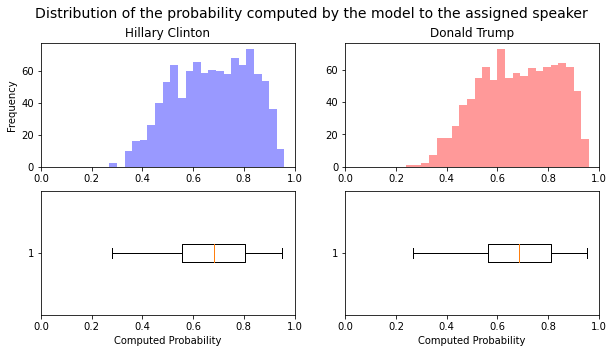

Hillary Clinton Summary Statistics


count    1000.000000
mean        0.675524
std         0.149497
min         0.281000
25%         0.557125
50%         0.682450
75%         0.802600
max         0.950900
Name: proba, dtype: float64


Donald Trump Summary Statistics


count    1000.000000
mean        0.675524
std         0.149497
min         0.281000
25%         0.557125
50%         0.682450
75%         0.802600
max         0.950900
Name: proba, dtype: float64

<Figure size 432x288 with 0 Axes>

In [10]:
n_bins = 40
proba_bins = [round((1 / n_bins), 2) * i for i in range(0, n_bins  + 1)]

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
fig.suptitle("Distribution of the probability computed by the model to the assigned speaker", fontsize=14)

axs[0, 0].set(xlim=(0, 1))
axs[0, 1].set(xlim=(0, 1))

axs[0, 0].hist(hc_sample['proba'], bins=proba_bins, color='b', alpha=0.4)
axs[0, 1].hist(dt_sample['proba'], bins=proba_bins, color='r', alpha=0.4)

axs[1, 0].set(xlim=(0, 1))
axs[1, 1].set(xlim=(0, 1))

axs[1, 0].boxplot(hc_sample['proba'], vert=False)
axs[1, 1].boxplot(dt_sample['proba'], vert=False)


axs[0, 0].set_ylabel('Frequency')
axs[0, 0].title.set_text('Hillary Clinton')

axs[0, 1].title.set_text('Donald Trump')

axs[1, 1].set_xlabel('Computed Probability')
axs[1, 0].set_xlabel('Computed Probability')

plt.show()
plt.clf()

print("Hillary Clinton Summary Statistics")
display(hc_sample['proba'].describe())
print()
print("Donald Trump Summary Statistics")
display(hc_sample['proba'].describe())

From plotting the distribution of probabilities which the model computed to the quotes it assigned to Trump and Hillary respectively we could now act in at least 3 ways:

1. Remove any quote which is below the min probability minus a small margin because they are outliers. **I.e. Only Remove outliers.**

2. Set the cutoff even higher because we decide to consider quotes with, ex. less than 0.4 probability assigned to the candidate being the speaker too weak to consider it in further analysis.

3. A further possibility could be to remove quotes, where the next best speaker assigned has a similair/close probability compare to the number one.
   
   Example: `[ [ 'Trump', 0.41 ], [ 'Kanye West', 0.39 ], ...]`

**TODO for later:** What should we do? What is scientifically sound? How do we motivate it?



**Filtering out datapoints with too low probability**

In [11]:
PROBAS_THRESHOLD = 0.5

In [12]:
df_3_1 = df_3

df_3_1 = df_3_1[df_3_1['proba'] >= PROBAS_THRESHOLD]

n_removed_lines = len(df_3) - len(df_3_1)
percentage_removed = (n_removed_lines / len(df_3 )) * 100

print("Removed {:,.0f} datapoints or {:,.2f}% of the dataset".format(n_removed_lines, percentage_removed))

Removed 20,124 datapoints or 13.96% of the dataset


### Filter: Remove Quotes with "nonsense" content

**TODO**: Define "nonsense" content and motivate.

## Data Analysis

In [13]:
blue_patch = mpatches.Patch(color='blue', alpha=0.4, label='Hillary Clinton')
red_patch = mpatches.Patch(color='red', alpha=0.4, label='Donald Trump')

### General Exploration

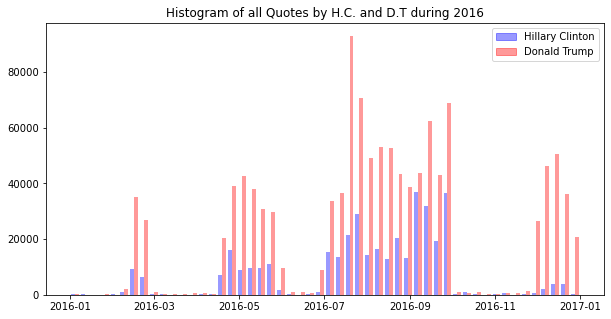

<Figure size 432x288 with 0 Axes>

In [14]:
n_bins = 52

plt.figure(figsize=(10,5))

plt.title("Histogram of all Quotes by H.C. and D.T during 2016")

df_2_hc = df_2[df_2['speaker'] == 'Hillary Clinton']
df_2_dt = df_2[df_2['speaker'] == 'Donald Trump']

plt.hist([df_2_hc['date'], df_2_dt['date']], weights=[df_2_hc['numOccurrences'], df_2_dt['numOccurrences']], bins=n_bins, color=["blue", "red"], alpha=0.4)

plt.legend(handles=[blue_patch, red_patch])

plt.show()
plt.clf()


**Questions arising**
- Why are there certain periods with barely any quotes?
- Is there something wrong/weird with the data?
- How can we test that everything is good?

### Q1: Media Bias

Do media outlets portray Trump and Clinton differently? Do media outlets quote the two candidates equally much? Does the bias of the news outlet correlate with the quotes they report?

Let's take two of the biggest outlets with political leaning views, CNN and Breitbart, and compare the distribution of Trump quotes with Clinton quotes, and also see how positive or negative they are.

The NLTK library will also be used for sentiment analysis later on.

In [15]:
sample.groupby(['speaker']).count().sort_values('quotation', ascending=False)['quotation']

speaker
Donald Trump              699
Hillary Clinton           288
President Donald Trump      8
Donald Trump Jr. .          3
president Donald Trump      2
Name: quotation, dtype: int64

**TODO:** Remove the wrong speakers...

#### Using NLTK’s Pre-Trained Sentiment Analyzer

We use NLTK VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tools

In [16]:
sia = SentimentIntensityAnalyzer()

trump_polarity_scores = dt_sample['quotation'].apply(sia.polarity_scores)
dt_sample['polarityScore'] = [score.get('compound') for score in trump_polarity_scores]

clinton_polarity_scores = hc_sample['quotation'].apply(sia.polarity_scores)
hc_sample['polarityScore'] = [score.get('compound') for score in clinton_polarity_scores]

<ipython-input-17-adcd8b555ba6>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_cnn['polarityScore'] = [score.get('compound') for score in trump_cnn_PS]
<ipython-input-17-adcd8b555ba6>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinton_cnn['polarityScore'] = [score.get('compound') for score in clinton_cnn_PS]


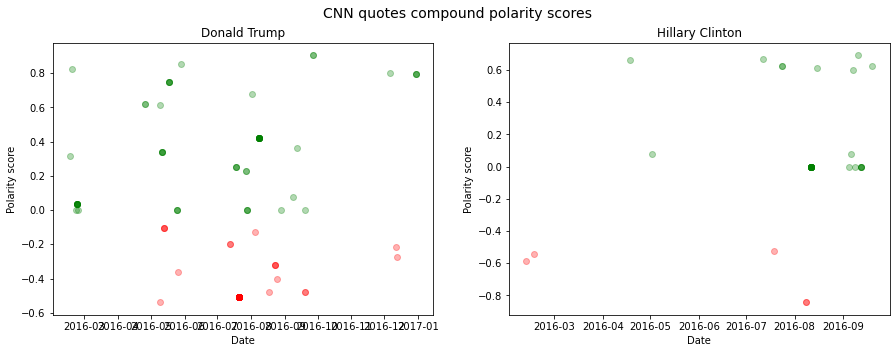

<Figure size 432x288 with 0 Axes>

In [17]:
trump_df = sample.loc[sample['speaker'] == 'Donald Trump']
clinton_df = sample.loc[sample['speaker'] == 'Hillary Clinton']

cnn_trump, cnn_clinton = [],[]

for i in range(len(trump_df)):
    for k in range(len(trump_df['urls'].iloc[i])):
        if trump_df['urls'].iloc[i][k].find('cnn') != -1:
            cnn_trump.append(i)

trump_cnn = trump_df.iloc[cnn_trump]

for i in range(len(clinton_df)):
    for k in range(len(clinton_df['urls'].iloc[i])):
        if clinton_df['urls'].iloc[i][k].find('cnn') != -1:
            cnn_clinton.append(i)

clinton_cnn = clinton_df.iloc[cnn_clinton]
        
trump_cnn_PS = trump_cnn['quotation'].apply(sia.polarity_scores)
trump_cnn['polarityScore'] = [score.get('compound') for score in trump_cnn_PS]
clinton_cnn_PS = clinton_cnn['quotation'].apply(sia.polarity_scores)
clinton_cnn['polarityScore'] = [score.get('compound') for score in clinton_cnn_PS]

trump_cnn_pos = trump_cnn[trump_cnn['polarityScore'] >= 0]
trump_cnn_neg = trump_cnn[trump_cnn['polarityScore'] < 0]
clinton_cnn_pos = clinton_cnn[clinton_cnn['polarityScore'] >= 0]
clinton_cnn_neg = clinton_cnn[clinton_cnn['polarityScore'] < 0]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(x=trump_cnn_pos['date'], y=trump_cnn_pos['polarityScore'], color='g', alpha=0.3, label="positive")
axs[0].scatter(x=trump_cnn_neg['date'], y=trump_cnn_neg['polarityScore'], color='r', alpha=0.3, label="negative")
axs[1].scatter(x=clinton_cnn_pos['date'], y=clinton_cnn_pos['polarityScore'], color='g', alpha=0.3, label="positive")
axs[1].scatter(x=clinton_cnn_neg['date'], y=clinton_cnn_neg['polarityScore'], color='r', alpha=0.3, label="positive")

fig.suptitle("CNN quotes compound polarity scores", fontsize=14)

axs[0].set_ylabel('Frequency')
axs[0].title.set_text('Donald Trump')

axs[1].title.set_text('Hillary Clinton')

axs[0].set_xlabel('Date')
axs[1].set_xlabel('Date')

axs[0].set_ylabel('Polarity score')
axs[1].set_ylabel('Polarity score')

plt.show()
plt.clf()

<ipython-input-18-a4629c6868d3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_breitbart['polarityScore'] = [score.get('compound') for score in trump_breitbart_PS]
<ipython-input-18-a4629c6868d3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinton_breitbart['polarityScore'] = [score.get('compound') for score in clinton_breitbart_PS]


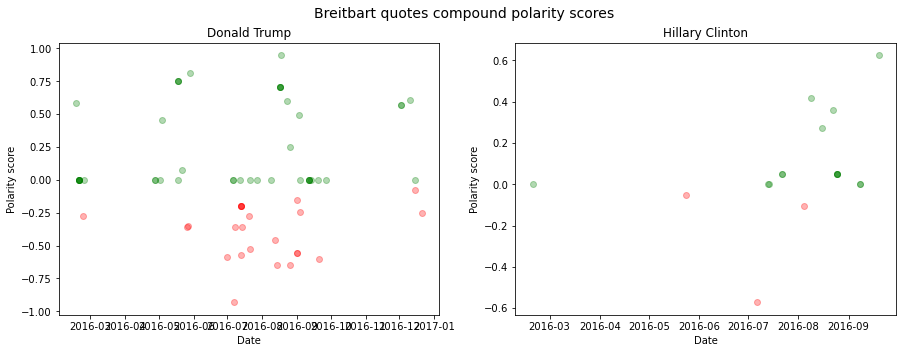

<Figure size 432x288 with 0 Axes>

In [18]:
breitbart_trump, breitbart_clinton = [],[]

for i in range(len(trump_df)):
    for k in range(len(trump_df['urls'].iloc[i])):
        if trump_df['urls'].iloc[i][k].find('breitbart') != -1:
            breitbart_trump.append(i)

trump_breitbart = trump_df.iloc[breitbart_trump]

for i in range(len(clinton_df)):
    for k in range(len(clinton_df['urls'].iloc[i])):
        if clinton_df['urls'].iloc[i][k].find('breitbart') != -1:
            breitbart_clinton.append(i)

clinton_breitbart = clinton_df.iloc[breitbart_clinton]
        
trump_breitbart_PS = trump_breitbart['quotation'].apply(sia.polarity_scores)
trump_breitbart['polarityScore'] = [score.get('compound') for score in trump_breitbart_PS]
clinton_breitbart_PS = clinton_breitbart['quotation'].apply(sia.polarity_scores)
clinton_breitbart['polarityScore'] = [score.get('compound') for score in clinton_breitbart_PS]

trump_breitbart_pos = trump_breitbart[trump_breitbart['polarityScore'] >= 0]
trump_breitbart_neg = trump_breitbart[trump_breitbart['polarityScore'] < 0]
clinton_breitbart_pos = clinton_breitbart[clinton_breitbart['polarityScore'] >= 0]
clinton_breitbart_neg = clinton_breitbart[clinton_breitbart['polarityScore'] < 0]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(x=trump_breitbart_pos['date'], y=trump_breitbart_pos['polarityScore'], color='g', alpha=0.3, label="positive")
axs[0].scatter(x=trump_breitbart_neg['date'], y=trump_breitbart_neg['polarityScore'], color='r', alpha=0.3, label="negative")
axs[1].scatter(x=clinton_breitbart_pos['date'], y=clinton_breitbart_pos['polarityScore'], color='g', alpha=0.3, label="positive")
axs[1].scatter(x=clinton_breitbart_neg['date'], y=clinton_breitbart_neg['polarityScore'], color='r', alpha=0.3, label="positive")

fig.suptitle("Breitbart quotes compound polarity scores", fontsize=14)

axs[0].set_ylabel('Frequency')
axs[0].title.set_text('Donald Trump')

axs[1].title.set_text('Hillary Clinton')

axs[0].set_xlabel('Date')
axs[1].set_xlabel('Date')

axs[0].set_ylabel('Polarity score')
axs[1].set_ylabel('Polarity score')

plt.show()
plt.clf()

This might be a very small sample size for the EDA, but we can already see substantial bias both in terms of the number of quotes by a candidate in each media outlet as well as the ratio of positive/negative quotes chosen by the CNN and Breitbart to represent the two Presidential candidates. This most likely holds true for other popular media outlets, especially those with politically inclined views.

### Q2: Political Issues

We want to track the different political topics that the candidates focused on according to the content of their quotes. From this we aim to learn the importance of the topics in a absolut relative context but also in regards to when a certain topic might have been very present and then. disappeared for some time. We furthermore want to see if there might be a candidate which sparked a topic or at least started talking/being quoted about it first.

Bewlow we show an example of a topic in regards to Obamacare, which we all remember to be a important topic during the debate.

In [19]:
OBAMACARE_REGEX = '(obama care)|obamacare' # Not perfect, proof of concept...

df_obamacare = df_2[df_2['quotation'].str.contains(pat = OBAMACARE_REGEX, regex = True, flags=re.IGNORECASE)].sort_values('date')
df_obamacare['date'] = df_obamacare['date'].apply(lambda date : date.date())

df_obamacare_hc = df_obamacare[df_obamacare['speaker'] == 'Hillary Clinton']
df_obamacare_dt = df_obamacare[df_obamacare['speaker'] == 'Donald Trump']

/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


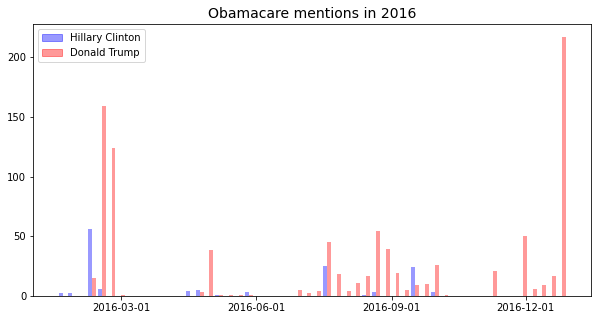

<Figure size 432x288 with 0 Axes>

In [20]:
BINS = 52
ticks = [f"2016-0{i * 3}-01" for i in range(1,4)] + ["2016-12-01"]

plt.figure(figsize=(10,5))
plt.title("Obamacare mentions in 2016", fontsize=14)

plt.hist([df_obamacare_hc['date'], df_obamacare_dt['date']], weights=[df_obamacare_hc['numOccurrences'], df_obamacare_dt['numOccurrences']], bins=BINS, color=["b", "r"], alpha=0.4)

plt.xticks(ticks)
plt.legend(handles=[blue_patch, red_patch])

plt.show()
plt.clf()

In [21]:
def quote_topics_histogram(df_hc, df_dt, bins=52, topic_name=""):
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    kwargs = {
        "alpha" : 0.4,
        "bins": bins,
    }

    axs[0].hist(df_hc['date'], weights=df_hc['numOccurrences'], color="b", **kwargs)
    axs[1].hist(df_dt['date'], weights=df_dt['numOccurrences'], color="r", **kwargs)

    fig.suptitle(f"Mentions of the Topic '{topic_name}' in 2016 by candidate", fontsize=16)

    axs[0].set_ylabel('Frequency')

    axs[0].title.set_text('Hillary Clinton')
    axs[0].set_xlabel('Date')

    axs[1].title.set_text('Donald Trump')
    axs[1].set_xlabel('Date')
    
    ticks = [f"2016-0{i * 3}-01" for i in range(1,4)] + ["2016-12-01"]

    axs[0].set_xticks(ticks)
    axs[1].set_xticks(ticks)
    
    plt.show()
    plt.clf()

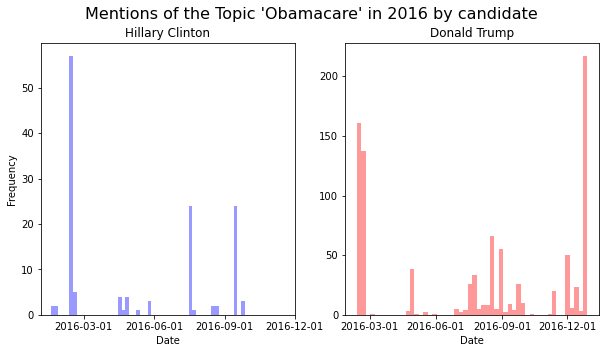

<Figure size 432x288 with 0 Axes>

In [22]:
# Example:
quote_topics_histogram(df_obamacare_hc, df_obamacare_dt, topic_name="Obamacare")

### Visualisation Idea

We have identified several topics which show a clear periodic difference in occurance and intensity. We aim to visualise this data as illustrated in the sketch below for the final project. We hope to show how several topics come and go throughout the campaign and are focused on with a different amount of attention/importance depending on the candidate. Ideally we would extend this visualisation further allowing the viewer to see the importance the citizen base gave the topics at each time or the extent to which media reported on it. It would be amazing to see if some topics had a trendsetter who started talking about it earier adn fiercly...

We believe that our first EDA supports our thesis that the data will allow us to visualise it in this way, that there is peridoicity and hoepefully many interesting insights.

![Visualisation Sketch](focus-topics-sketch.jpg)

## Q3: Language

### a) Intellectuality of Language

Idea 1: Count the syllables in each candidate's consolidated quotes and compare distributions

In [23]:
def syllables_hist(dt_text: str, hc_text: str):

    dt_syl = list(map(syllables.estimate, dt_text.split()))
    hc_syl = list(map(syllables.estimate, hc_text.split()))

    kwargs = {
        "x"    : [hc_syl, dt_syl],
        "label" : ["Hillary Clinton", "Donald Trump"],
        "color" : ["b", "r"],
        "alpha" : 0.4,
        "bins" : range(1, 6),
        "density" : True,
        "align": "left",
    }

    plt.hist(**kwargs)
    plt.legend()
    plt.title("Histogram of number of syllables", fontsize=16)
    plt.xlabel("Number of syllables in a Word")
    plt.ylabel("Probability of Occuring")

    # TODO generalize this
    plt.xticks(range(1, 5), range(1, 5))

    plt.show()

In [24]:
hc_text = ' '.join(hc_sample["quotation"])
dt_text = ' '.join(dt_sample["quotation"])

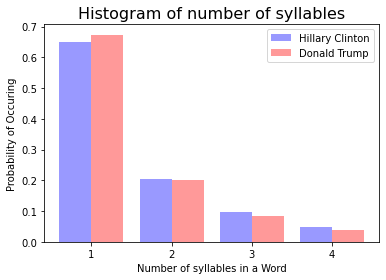

In [25]:
syllables_hist(dt_text, hc_text)

Idea 2: Look at the CEFR language level. We can measure the language level for all words in each candidate's consolidated quotes and compare the distributions.

But first we need to get data on words. We have the HTML for a web page containing these data, and we can put them in the form of a CSV file.

In [26]:
def bs_to_csv(soup, csv_writer):
    table = soup.find("tbody")
    tr_rows = table.find_all("tr")
    csv_writer.writerow(["word", "guideword", "level", "part of speech", "topic"])
    csv_writer.writerows(
        [[t.text for t in r.find_all("td")][:-1] for r in tr_rows]
    )

In [27]:
# Scrape the HTML file and write in CSV format to file.
with open(CEFR_HTML_IN) as fp, open(CEFR_CSV_OUT, 'w') as csv_out:
    soup = BeautifulSoup(fp)
    csv_writer = csv.writer(csv_out, delimiter=',')
    bs_to_csv(soup, csv_writer)

In [28]:
df_cefr = pd.read_csv(CEFR_CSV_OUT)

display(df_cefr)

,word,guideword,level,part of speech,topic
0,cattle,NaN,B1,NaN,animals
1,clothes,NaN,A1,NaN,clothes
2,albeit,NaN,C2,NaN,NaN
3,and,ALSO,A1,NaN,communication
4,and,AFTER,A1,NaN,communication
...,...,...,...,...,...
15384,with bated breath,IDIOM,C2,phrase,NaN
15385,be lost for words,IDIOM,C2,phrase,NaN
15386,by word of mouth,IDIOM,C2,phrase,NaN
15387,not be the end of the world,IDIOM,C2,phrase,NaN


The data includes idioms as well as nouns; this is intelligible for a human, but it might be a bit of trouble to make it work here, so we remove them.
We'll only need the `word` and `level` columns, so we remove the others as well.

In [29]:
df_cefr = df_cefr[[len(w.split()) == 1 for w in df_cefr["word"]]]\
                 .filter(items=["word", "level"])

Now we set everything to lowercase. Also it seems that some words have punctuation surrounding them, which is not desirable.

In [30]:
df_cefr["word"] = df_cefr["word"].transform(
    lambda w: w.lower()\
               .translate(str.maketrans('', '', string.punctuation)))
display(df_cefr)

,word,level
0,cattle,B1
1,clothes,A1
2,albeit,C2
3,and,A1
4,and,A1
...,...,...
14565,street,A1
14914,things,A1
14918,studies,A2
14941,things,B1


Also, the same word can appear multiple times (as there might be different phrases in which the word means something slightly different) so we aggregate the levels using the median level.

In [31]:
cefr_level_map = {
    "A1": 1,
    "A2": 2,
    "B1": 3,
    "B2": 4,
    "C1": 5,
    "C2": 6,
}

In [32]:
df_cefr_copy = df_cefr.copy(deep=True)

In [33]:
# Use the map to transform the level column

df_cefr.level = df_cefr_copy["level"].map(cefr_level_map)

In [34]:
# Aggregate with the median

df_cefr = df_cefr.groupby("word").agg("median").reset_index()
display(df_cefr)

,word,level
0,a,2.0
1,abandon,4.5
2,abandoned,4.0
3,ability,3.0
4,able,6.0
...,...,...
6508,zero,2.5
6509,zipper,4.0
6510,zone,3.0
6511,zoo,1.0


Finally we change the index to the word itself to facilitate searching.

In [35]:
df_cefr.index = df_cefr.word
df_cefr = df_cefr.filter(items=["level"])

Now we can finally apply this to our dataset.

In [36]:
cefr_data = pd.read_csv("cefr_data_clean.csv", index_col="word")
cefr_data.loc["he"].loc["level"]

1.0

In [37]:
def cefr_level_hist(dt_text: str, hc_text: str):

    cefr_data = pd.read_csv("cefr_data_clean.csv", index_col="word")
    cefr_data.loc["he"].loc["level"]
    
    level = lambda w: cefr_data.loc[w].loc["level"] if w in cefr_data.index else 0

    dt_level = list(map(level, dt_text.split()))
    hc_level = list(map(level, hc_text.split()))

    kwargs = {
        "x"    : [hc_level, dt_level],
        "label" : ["Hillary Clinton", "Donald Trump"],
        "color" : ["b", "r"],
        "alpha" : 0.4,
        "bins" : range(0, 7),
        "density" : True,
        "align": "left",
    }
    plt.hist(**kwargs)
    plt.legend()
    plt.title("Histogram of English level of words", fontsize=16)
    plt.xlabel("English level")
    plt.ylabel("Probability")

    plt.xticks(range(0, 7), ["NA", "A1", "A2", "B1", "B2", "C1", "C2"])

    plt.show()

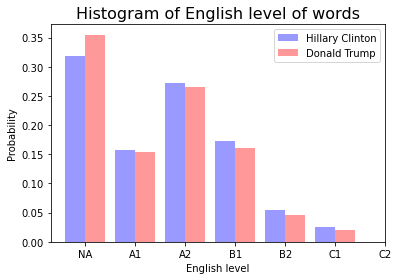

In [38]:
cefr_level_hist(dt_text.lower(), hc_text.lower())

There seems to be little difference in terms of language levels, but note how many words were not accounted for; this is due in part to limitations of our CEFR dataset, and also to the fact that some words appear in text in different forms (e.g. a verb conjugated to the past tense). This particular issue will be remedied by "stemming" the words to reduce them to their "base" form.

### Ideas

- Who is are Trump and Clinton most confused with? Using the other speaker attributions in the quotas list.

### b) Sentiment Analysis

In [39]:
sample.groupby(['speaker']).count().sort_values('quotation', ascending=False)['quotation']

speaker
Donald Trump              699
Hillary Clinton           288
President Donald Trump      8
Donald Trump Jr. .          3
president Donald Trump      2
Name: quotation, dtype: int64

##### Using NLTK’s Pre-Trained Sentiment Analyzer
We use NLTK VADER (Valence Aware Dictionary and sEntiment Reasoner) sentiment analysis tools

In [40]:
sia = SentimentIntensityAnalyzer()

In [41]:
trump_polarity_scores = dt_sample['quotation'].apply(sia.polarity_scores)
dt_sample['polarityScore'] = [score.get('compound') for score in trump_polarity_scores]

clinton_polarity_scores = hc_sample['quotation'].apply(sia.polarity_scores)
hc_sample['polarityScore'] = [score.get('compound') for score in clinton_polarity_scores]

#### Donald Trump's 5 most positive and negative quotes

In [42]:
print("Trump's 5 most positive quotes:")
# trump_df.sort_values('polarityScore', ascending=False)[['quotation', 'polarityScore']].head(5)
[print("[+]", quote) for quote in dt_sample.sort_values('polarityScore', ascending=False)['quotation'].head(5).tolist()]

print("\n---\n")

print("Trump's 5 most negative quotes:")
# trump_df.sort_values('polarityScore', ascending=True)[['quotation', 'polarityScore']].head(5).tolist()
[print("[-]", quote) for quote in dt_sample.sort_values('polarityScore', ascending=True)['quotation'].head(5).tolist()]


Trump's 5 most positive quotes:
[+] We weren't expected to win too much and now we're winning, winning, winning the country. And soon the country is going to start winning, winning, winning. We won with the evangelicals. We won with the young. We won with the old. We won with the highly educated. We won with the poorly educated. I love the uneducated!
[+] It is a great honor to have won both West Virginia and Nebraska, especially by such massive margins. My time spent in both states was a wonderful and enlightening experience for me. I learned a lot, and that knowledge will be put to good use towards the creation of businesses, jobs, and the strengthening and revival of their economies.
[+] support research on best practices and state of the art treatments to keep our veterans alive, healthy and whole. With these steps, the Trump plan will help the veteran community put the unnecessary stigma surrounding mental health behind them and instead encourage acceptance and treatment in our gr

[None, None, None, None, None]

#### Hillary Clinton's 5 most positive and negative quotes

In [43]:
print("Hillary Clinton's 5 most positive quotes:")
# clinton_df.sort_values('polarityScore', ascending=False)[['quotation', 'polarityScore']].head(5)
[print("[+]", quote) for quote in hc_sample.sort_values('polarityScore', ascending=False)['quotation'].head(5).tolist()]

print("---")

print("Hillary Clinton's 5 most negative quotes:")
# clinton_df.sort_values('polarityScore', ascending=True)[['quotation', 'polarityScore']].head(5).tolist()
[print("[-]", quote) for quote in hc_sample.sort_values('polarityScore', ascending=True)['quotation'].head(5).tolist()]


Hillary Clinton's 5 most positive quotes:
[+] UNITE HERE knows, as I do, that America is stronger together. Workers' rights to organize, to bargain collectively, to be safe on the job, and to retire with dignity and security after years of hard work are fundamental to our country and to our economy. In too many statehouses across the country -- and even in the halls of Congress -- these rights are under concerted attack by Republicans and big corporations who have forgotten that a strong economy requires a strong workforce. If I am elected President, workers will always have a seat at the table and a champion in the White House. I'll protect and build upon President Obama's executive actions on immigration and will introduce legislation to at last secure comprehensive immigration reform with a path to citizenship within my first 100 days. And I'll always have workers' backs -- because when workers are strong, America is strong.
[+] I'm going to do everything I can so you don't have to 

[None, None, None, None, None]

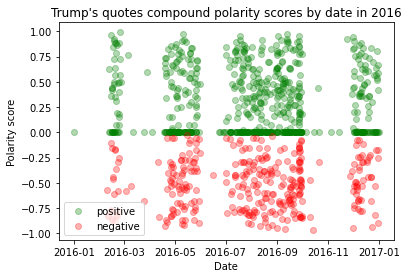

In [44]:
trump_df_pos = dt_sample[dt_sample['polarityScore'] >= 0]
trump_df_neg = dt_sample[dt_sample['polarityScore'] < 0]

plt.scatter(x=trump_df_pos['date'], y=trump_df_pos['polarityScore'], color='g', alpha=0.3, label="positive")
plt.scatter(x=trump_df_neg['date'], y=trump_df_neg['polarityScore'], color='r', alpha=0.3, label="negative")

plt.title("Trump's quotes compound polarity scores by date in 2016")
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()

plt.show()

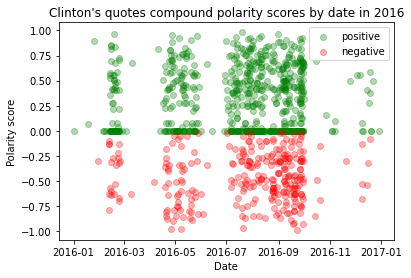

In [45]:
clinton_df_pos = hc_sample[hc_sample['polarityScore'] >= 0]
clinton_df_neg = hc_sample[hc_sample['polarityScore'] < 0]

plt.scatter(x=clinton_df_pos['date'], y=clinton_df_pos['polarityScore'], color='g', alpha=0.3, label="positive")
plt.scatter(x=clinton_df_neg['date'], y=clinton_df_neg['polarityScore'], color='r', alpha=0.3, label="negative")

plt.title("Clinton's quotes compound polarity scores by date in 2016")
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()

plt.show()

In [46]:
trump_df_pos.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,proba,polarityScore
31385,2016-12-07-094759,So sometimes in order to get jobs going and th...,Donald Trump,"[Q22686, Q27947481]",2016-12-07 18:41:41,4,"[[Donald Trump, 0.5989], [President Donald Tru...",[http://www.thefiscaltimes.com/2016/12/07/Trum...,E,0.5989,0.3818
13094,2016-09-27-040206,"I have a feeling that by, the end of this even...",Donald Trump,"[Q22686, Q27947481]",2016-09-27 05:02:51,1,"[[Donald Trump, 0.5729], [None, 0.2905], [Hill...",[http://www.usnews.com/news/articles/2016-09-2...,E,0.5729,0.1280
62613,2016-08-13-014672,"Hillary wants to abolish, essentially abolish,...",Donald Trump,"[Q22686, Q27947481]",2016-08-13 21:00:00,1,"[[Donald Trump, 0.7354], [None, 0.2646]]",[http://dailyprogress.com/starexponent/opinion...,E,0.7354,0.0000
135161,2016-09-28-147879,"We're going to end the Clinton corruption,",Donald Trump,"[Q22686, Q27947481]",2016-09-28 22:00:00,5,"[[Donald Trump, 0.6232], [None, 0.325], [Hilla...",[http://journalstar.com/news/local/govt-and-po...,E,0.6232,0.0000
103111,2016-09-29-105854,She put the office of Secretary of State up fo...,Donald Trump,"[Q22686, Q27947481]",2016-09-29 23:18:17,2,"[[Donald Trump, 0.578], [None, 0.3775], [Hilla...",[http://www.breitbart.com/2016-presidential-ra...,E,0.5780,0.0000


### Sentiment analysis on the target of quotes. 

For instance, Trump calling Clinton "Crooked Hillary" would be a negative statement about Presidential candidate Clinton. This will be done for a number of politicians, including: Hillary Clinton, Nancy Pelosi, Barack Obama, Bernie Sanders, Elizabeth Warren, Ted Cruz, Mike Pence, and Mitch McConnell.

In [47]:
trump_df = sample.loc[sample['speaker'] == 'Donald Trump']
clinton_df = sample.loc[sample['speaker'] == 'Hillary Clinton']

trump_on_clinton = trump_df[trump_df['quotation'].str.contains('clinton|hillary', case=False)]
trump_on_obama = trump_df[trump_df['quotation'].str.contains('obama|barack', case=False)]
trump_on_sanders = trump_df[trump_df['quotation'].str.contains('bernie|sanders', case=False)]

clinton_on_trump = clinton_df[clinton_df['quotation'].str.contains('trump|donald', case=False)]

In [48]:
trump_on_clinton_PS = trump_on_clinton['quotation'].apply(sia.polarity_scores)
trump_on_clinton['polarityScore'] = [score.get('compound') for score in trump_on_clinton_PS]

trump_on_obama_PS = trump_on_obama['quotation'].apply(sia.polarity_scores)
trump_on_obama['polarityScore'] = [score.get('compound') for score in trump_on_obama_PS]

<ipython-input-48-4f77fbdc38e0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_on_clinton['polarityScore'] = [score.get('compound') for score in trump_on_clinton_PS]
<ipython-input-48-4f77fbdc38e0>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_on_obama['polarityScore'] = [score.get('compound') for score in trump_on_obama_PS]


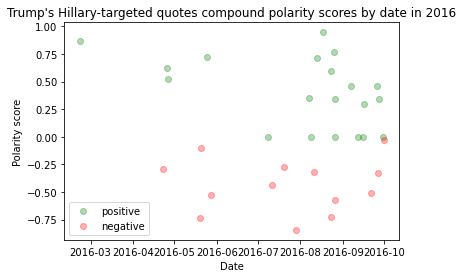

In [49]:
trump_on_clinton_pos = trump_on_clinton[trump_on_clinton['polarityScore'] >= 0]
trump_on_clinton_neg = trump_on_clinton[trump_on_clinton['polarityScore'] < 0]

plt.scatter(x=trump_on_clinton_pos['date'], y=trump_on_clinton_pos['polarityScore'], color='g', alpha=0.3, label="positive")
plt.scatter(x=trump_on_clinton_neg['date'], y=trump_on_clinton_neg['polarityScore'], color='r', alpha=0.3, label="negative")

plt.title("Trump's Hillary-targeted quotes compound polarity scores by date in 2016")
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()

plt.show()

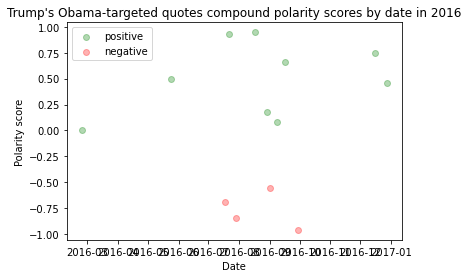

In [50]:
trump_on_obama_pos = trump_on_obama[trump_on_obama['polarityScore'] >= 0]
trump_on_obama_neg = trump_on_obama[trump_on_obama['polarityScore'] < 0]

plt.scatter(x=trump_on_obama_pos['date'], y=trump_on_obama_pos['polarityScore'], color='g', alpha=0.3, label="positive")
plt.scatter(x=trump_on_obama_neg['date'], y=trump_on_obama_neg['polarityScore'], color='r', alpha=0.3, label="negative")

plt.title("Trump's Obama-targeted quotes compound polarity scores by date in 2016")
plt.xlabel('Date')
plt.ylabel('Polarity score')
plt.legend()

plt.show()

Perhaps a next step would be to compare this with a baseline ratio of positive/negative words. For instance, maybe on average people say 70% positive things and 30% negative. Knowing this could help compare results with Trump and Clinton.

### Using BERT for sentiment analysis using quote vector embedding

In [51]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [52]:
trump_df['quotation'].iloc[500]

'Putin has been a leader, far more than our president.'

In [53]:
# Add the special tokens.
trump_df['marked'] = "[CLS] " + trump_df['quotation'] + " [SEP]"

trump_df['tokenized'] = trump_df['marked']
trump_df['indexed'] = trump_df['marked']
trump_df['seg_ids'] = trump_df['marked']
trump_df['tokens_tensor'] = trump_df['marked']
trump_df['seg_tensors'] = trump_df['marked']

# Split the sentence into tokens.
for i in range(len(trump_df)):
    trump_df['tokenized'].iloc[i] = tokenizer.tokenize(trump_df['marked'].iloc[i])
    # Map the token strings to their vocabulary indeces.
    trump_df['indexed'].iloc[i] = tokenizer.convert_tokens_to_ids(trump_df['tokenized'].iloc[i])
    trump_df['seg_ids'].iloc[i] = [1] * len(trump_df['tokenized'].iloc[i])
    # Convert inputs to PyTorch tensors
    trump_df['tokens_tensor'].iloc[i] = torch.tensor([trump_df['indexed'].iloc[i]])
    trump_df['seg_tensors'].iloc[i] = torch.tensor([trump_df['seg_ids'].iloc[i]])

<ipython-input-53-c217cf96f8c9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_df['marked'] = "[CLS] " + trump_df['quotation'] + " [SEP]"
<ipython-input-53-c217cf96f8c9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trump_df['tokenized'] = trump_df['marked']
<ipython-input-53-c217cf96f8c9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

NameError: name 'torch' is not defined

#### BERT Next Steps

The next step is to evaluate BERT on our quotations, and fetch the hidden states of the network. We would then create word and sentence vectors from our hidden states. This creates 768-dimensional token embedding vectors, on which we can then apply principal component analysis to plot the results using 2 axes.